# Stock Forecast
- DATA: [Yahoo Finance](https://finance.yahoo.com/)

## 🥇루브릭 기준
1. 시계열의 안정성이 충분히 확인되었는가?
   - 플로팅과 adfuller 메소드가 모두 적절히 사용되었음
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
   - p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
   - 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨 

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# STEP 1 : 시계열 데이터 준비
- DATA: SAMSUNG

In [3]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행

<AxesSubplot:xlabel='Date'>

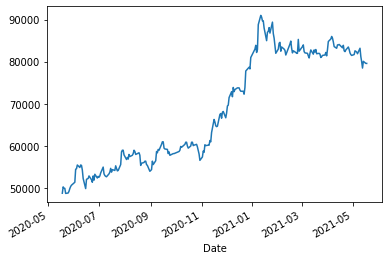

In [4]:
ts.plot()

In [6]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [7]:
# 로그 변환 시도 
ts_log = np.log(ts)

<AxesSubplot:xlabel='Date'>

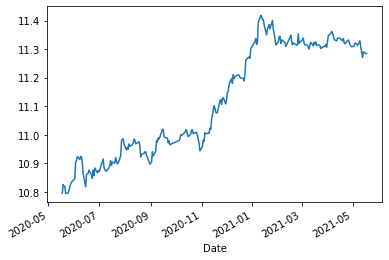

In [9]:
ts_log.plot()

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [10]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [11]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

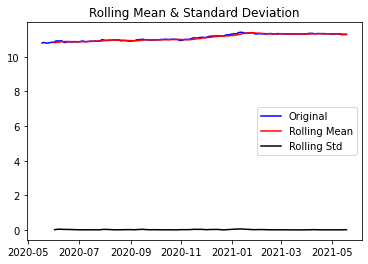

In [12]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [13]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


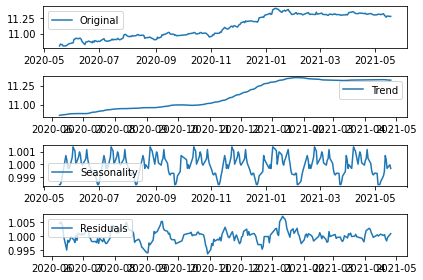

In [14]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [15]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성

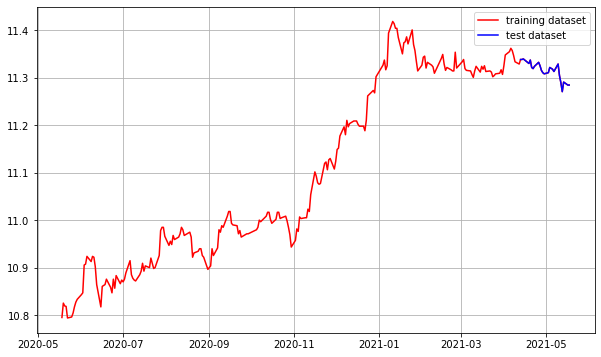

In [16]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

- PACF를 보고 AR 모형의 p를 결정한다 : 1이라고 볼 수 있음
- ACF를 보고 MA 모형의 q를 결정한다 : 명확히 결정할 수 없음. 0으로 둬 보자.

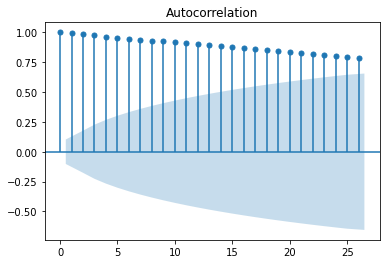

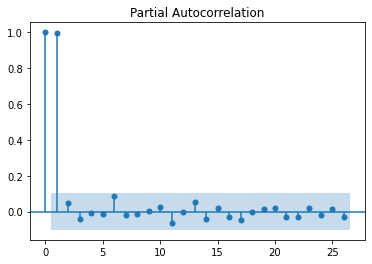

In [67]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


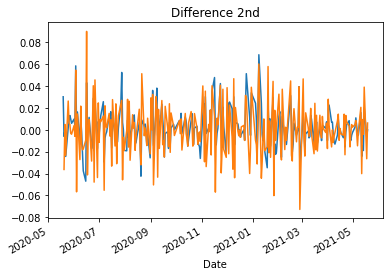

In [18]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [29]:
def ARIMAtest(train_data, test_data, p, d, q):
    # Build Model
    model = ARIMA(train_data, order=(1, 1, 24))  
    fitted_m = model.fit(disp=-1)  
    print(fitted_m.summary())
    
    fitted_m.plot_predict()
    
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))
    

In [69]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 1)) 
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  328
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 479.764
Method:                       css-mle   S.D. of innovations              0.056
Date:                Tue, 07 Sep 2021   AIC                           -951.528
Time:                        14:56:43   BIC                           -936.356
Sample:                    09-06-2020   HQIC                          -945.475
                         - 07-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0061      0.003      2.039      0.041       0.000       0.012
ar.L1.D.Close    -0.8496      0.103     -8.256      0.000      -1.051      -0.648
ma.L1.D.Close     0.7825      0.119     

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


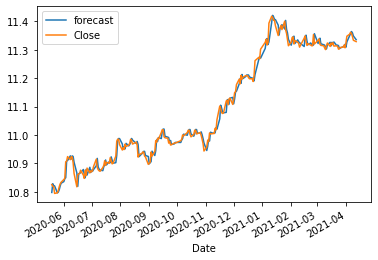

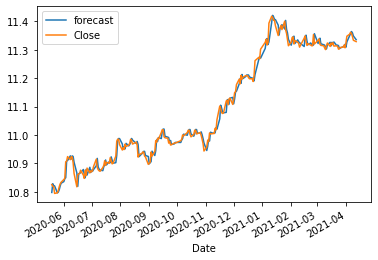

In [23]:
fitted_m.plot_predict()

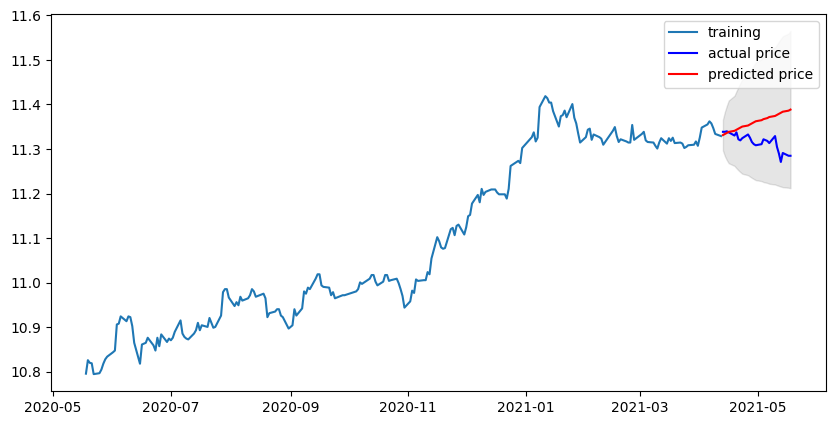

In [24]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [27]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


In [30]:
ARIMAtest(train_data, test_data, 1, 2, 0)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

KeyboardInterrupt: 

# STEP 7 : 다른 주식 종목 예측해 보기
## BITCOIN

In [22]:
!ls

 BTC-USD.csv   DOGE-USD.csv		   ETH-USD.csv
 data	      '[E-14] Stock Price.ipynb'  '[EXP] 14 예제.ipynb'


In [31]:
dataset_filepath = './BTC-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-05    10169.567383
2020-09-06    10280.351563
2020-09-07    10369.563477
2020-09-08    10131.516602
2020-09-09    10242.347656
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행

In [32]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

<AxesSubplot:xlabel='Date'>

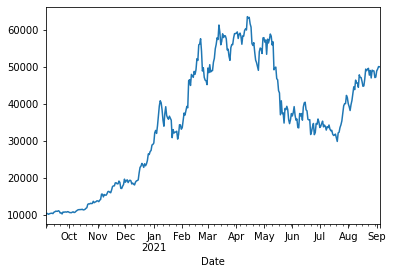

In [33]:
ts.plot()

<AxesSubplot:xlabel='Date'>

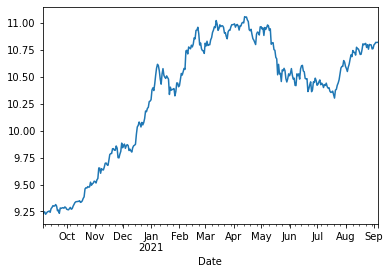

In [36]:
# 로그 변환 시도 
ts_log = np.log(ts)
ts_log.plot()

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

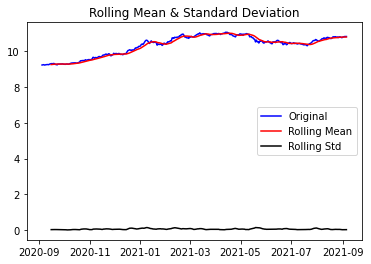

Results of Dickey-Fuller Test:
Test Statistic                  -1.828635
p-value                          0.366341
#Lags Used                       0.000000
Number of Observations Used    365.000000
Critical Value (1%)             -3.448394
Critical Value (5%)             -2.869491
Critical Value (10%)            -2.571006
dtype: float64


In [43]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

 - dickey fuller test의 귀무가설을 기각하지 못해 비정상성을 따르는 데이터라고 볼 수 있다. 따라서 시계열 분해를 시도한다.

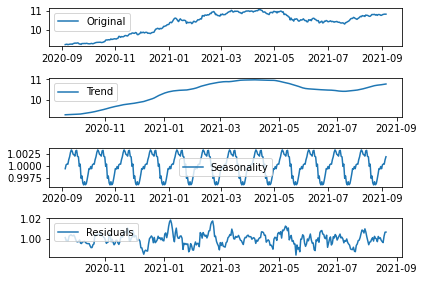

In [44]:
#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [42]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.277977e+00
p-value                        3.858469e-08
#Lags Used                     0.000000e+00
Number of Observations Used    3.350000e+02
Critical Value (1%)           -3.450022e+00
Critical Value (5%)           -2.870207e+00
Critical Value (10%)          -2.571387e+00
dtype: float64


- 잔차는 dickey fuller test의 귀무가설을 기각하고 정상성을 만족한다.

# STEP 4 : 학습, 테스트 데이터셋 생성

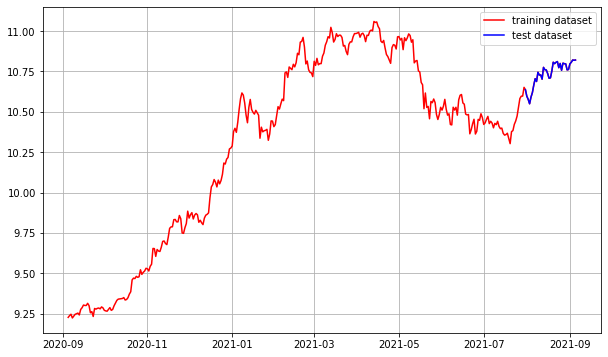

In [45]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
(p, d, q)
- ACF, PACF 그려보기 -> p,q 구하기 : 10, 1
- 차분 안정성 확인 -> d 구하기

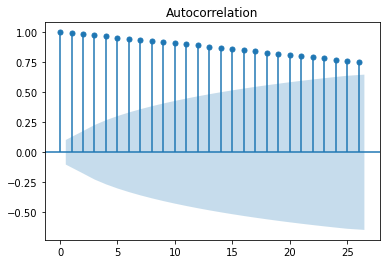

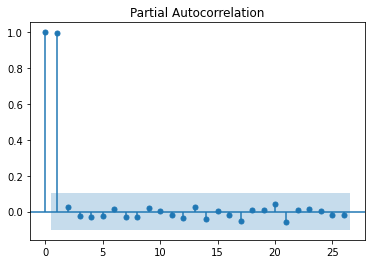

In [40]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -20.232366
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.081654e+01
p-value                        1.850987e-19
#Lags Used                     9.000000e+00
Number of Observations Used    3.540000e+02
Critical Value (1%)           -3.448958e+00
Critical Value (5%)           -2.869739e+00
Critical Value (10%)          -2.571138e+00
dtype: float64


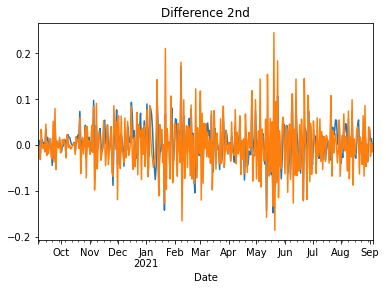

In [41]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

- 여기서 ARIMA모델은 차분을 통한 정상화 작업을 진행해준다. 따라서 원 데이터인 ts_log를 활용하여 ARIMA모델을 적용한다. 이때, d = 1 또는 2를 준다.

In [46]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 10))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  328
Model:                ARIMA(1, 1, 10)   Log Likelihood                 587.461
Method:                       css-mle   S.D. of innovations              0.040
Date:                Sun, 05 Sep 2021   AIC                          -1148.923
Time:                        13:47:57   BIC                          -1099.613
Sample:                    09-06-2020   HQIC                         -1129.250
                         - 07-30-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0046      0.003      1.533      0.125      -0.001       0.010
ar.L1.D.Close      0.3861      0.286      1.351      0.177      -0.174       0.946
ma.L1.D.Close     -0.4563      0.284

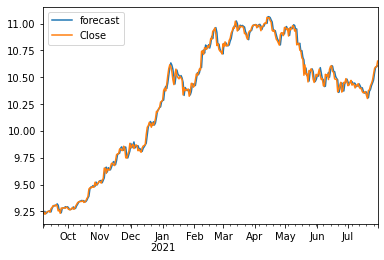

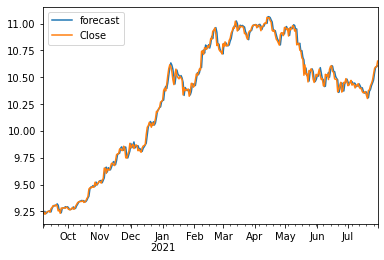

In [47]:
fitted_m.plot_predict()

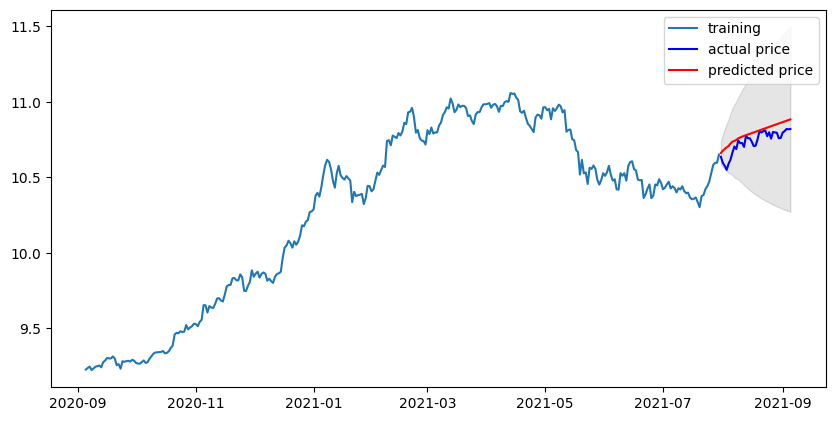

In [48]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [49]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  9693990.260353668
MAE:  2737.411078393811
RMSE:  3113.5173454396663
MAPE: 6.09%


## ETHURIUM

In [50]:
!ls

 BTC-USD.csv   DOGE-USD.csv		   ETH-USD.csv
 data	      '[E-14] Stock Price.ipynb'  '[EXP] 14 예제.ipynb'


In [46]:
dataset_filepath = './ETH-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-05    335.260071
2020-09-06    353.362274
2020-09-07    352.673492
2020-09-08    337.602112
2020-09-09    351.110016
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행

In [47]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [48]:
# 로그 변환 시도 
ts_log = np.log(ts)

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

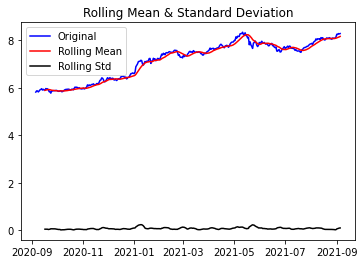

In [49]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [50]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.892266
p-value                          0.790509
#Lags Used                      12.000000
Number of Observations Used    353.000000
Critical Value (1%)             -3.449011
Critical Value (5%)             -2.869763
Critical Value (10%)            -2.571151
dtype: float64


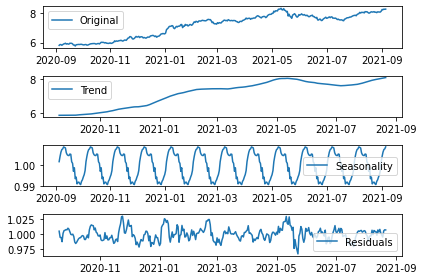

In [51]:
#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [52]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.717696e+00
p-value                        3.547478e-09
#Lags Used                     1.000000e+01
Number of Observations Used    3.250000e+02
Critical Value (1%)           -3.450632e+00
Critical Value (5%)           -2.870474e+00
Critical Value (10%)          -2.571530e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성

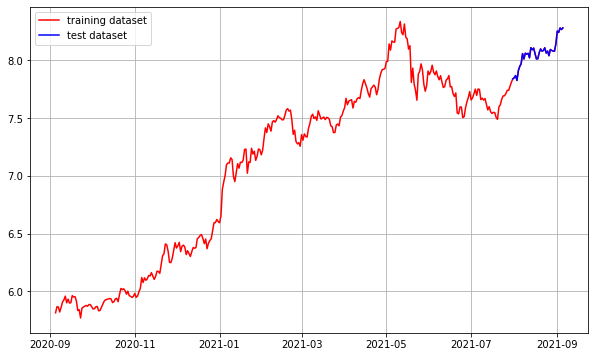

In [53]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

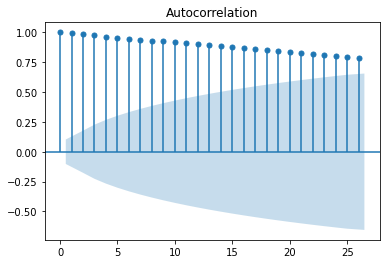

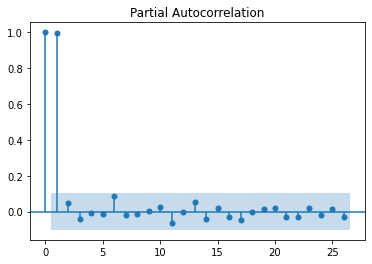

In [54]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -5.746846e+00
p-value                        6.093474e-07
#Lags Used                     1.100000e+01
Number of Observations Used    3.530000e+02
Critical Value (1%)           -3.449011e+00
Critical Value (5%)           -2.869763e+00
Critical Value (10%)          -2.571151e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.194298e+01
p-value                        4.497826e-22
#Lags Used                     8.000000e+00
Number of Observations Used    3.550000e+02
Critical Value (1%)           -3.448906e+00
Critical Value (5%)           -2.869716e+00
Critical Value (10%)          -2.571126e+00
dtype: float64


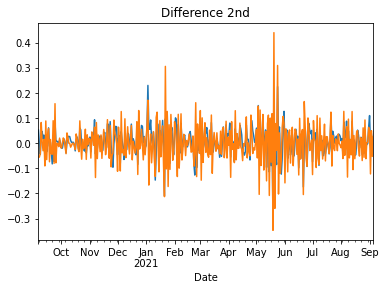

In [55]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [62]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  328
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 479.764
Method:                       css-mle   S.D. of innovations              0.056
Date:                Tue, 07 Sep 2021   AIC                           -951.528
Time:                        14:55:35   BIC                           -936.356
Sample:                    09-06-2020   HQIC                          -945.475
                         - 07-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0061      0.003      2.039      0.041       0.000       0.012
ar.L1.D.Close    -0.8496      0.103     -8.256      0.000      -1.051      -0.648
ma.L1.D.Close     0.7825      0.119     

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

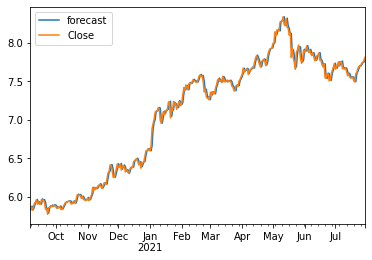

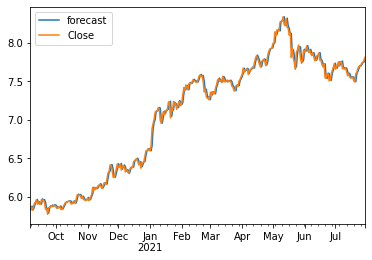

In [63]:
fitted_m.plot_predict()

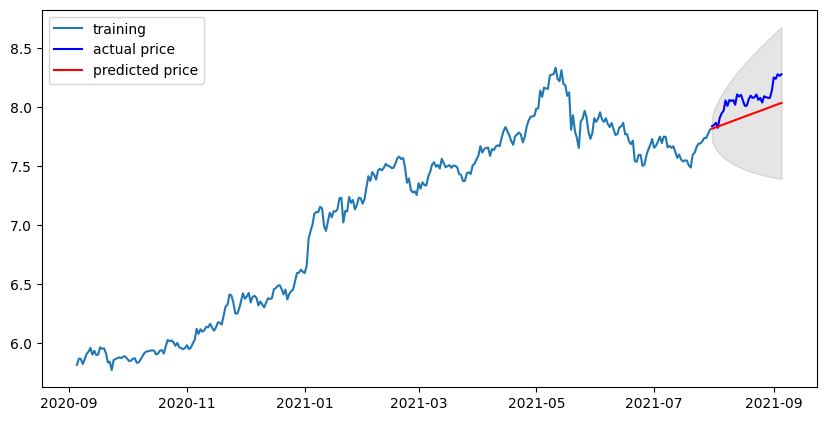

In [65]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [66]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  220022.0357748945
MAE:  413.8188047175167
RMSE:  469.06506560912686
MAPE: 12.44%


## DOGECOIN

In [22]:
!ls

 BTC-USD.csv   DOGE-USD.csv		   ETH-USD.csv
 data	      '[E-14] Stock Price.ipynb'  '[EXP] 14 예제.ipynb'


In [31]:
dataset_filepath = './DOGE-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-05    0.002758
2020-09-06    0.002787
2020-09-07    0.002811
2020-09-08    0.002756
2020-09-09    0.002779
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행

In [32]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

<AxesSubplot:xlabel='Date'>

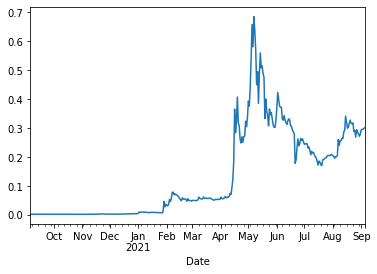

In [33]:
ts.plot()

<AxesSubplot:xlabel='Date'>

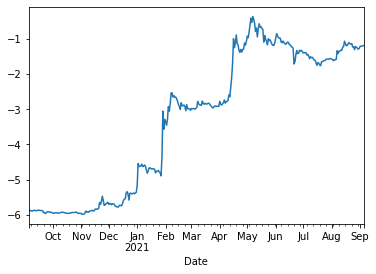

In [34]:
# 로그 변환 시도 
ts_log = np.log(ts)
ts_log.plot()

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

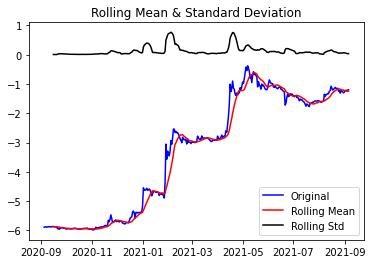

In [35]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [36]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.834655
p-value                          0.808730
#Lags Used                       0.000000
Number of Observations Used    365.000000
Critical Value (1%)             -3.448394
Critical Value (5%)             -2.869491
Critical Value (10%)            -2.571006
dtype: float64


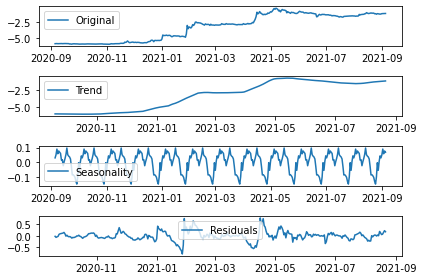

In [38]:
#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='period', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [39]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.234029e+00
p-value                        4.874817e-08
#Lags Used                     3.000000e+00
Number of Observations Used    3.320000e+02
Critical Value (1%)           -3.450201e+00
Critical Value (5%)           -2.870285e+00
Critical Value (10%)          -2.571429e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성

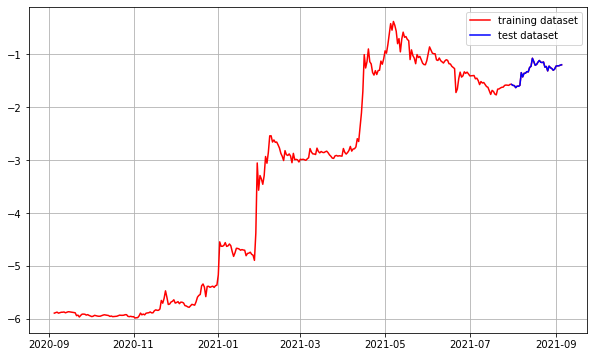

In [40]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
(p, d, q)
- ACF, PACF 그려보기 -> p,q 구하기 : 10, 1
- 차분 안정성 확인 -> d 구하기

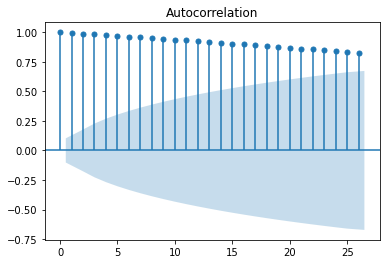

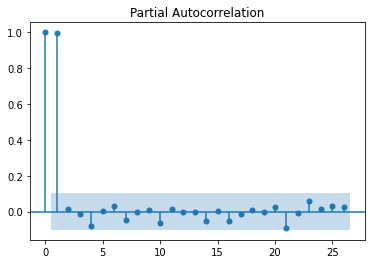

In [41]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -19.606756
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.689192e+00
p-value                        4.084299e-14
#Lags Used                     1.300000e+01
Number of Observations Used    3.500000e+02
Critical Value (1%)           -3.449173e+00
Critical Value (5%)           -2.869833e+00
Critical Value (10%)          -2.571188e+00
dtype: float64


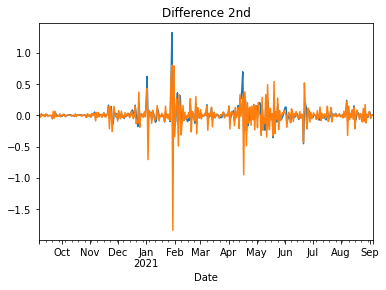

In [42]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [43]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  328
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 196.577
Method:                       css-mle   S.D. of innovations              0.133
Date:                Tue, 07 Sep 2021   AIC                           -387.155
Time:                        14:53:30   BIC                           -375.776
Sample:                    09-06-2020   HQIC                          -382.615
                         - 07-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0132      0.007      1.841      0.066      -0.001       0.027
ar.L1.D.Close    -0.0243      0.055     -0.442      0.659      -0.132       0.084
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

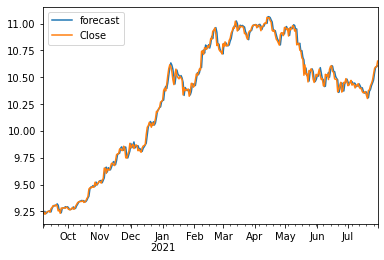

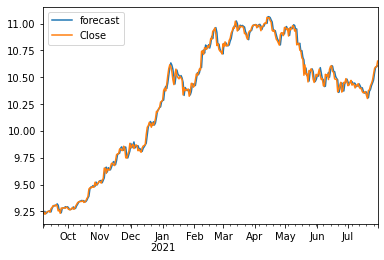

In [47]:
fitted_m.plot_predict()

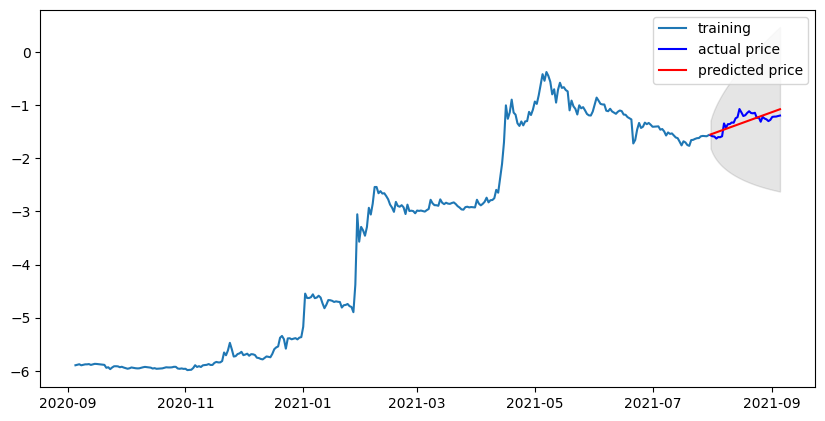

In [44]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [45]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  0.001079545109600097
MAE:  0.02846951214349989
RMSE:  0.032856431784356877
MAPE: 10.09%


# 회고
- 이번 노드는 주식 데이터를 시계열 분석을 통해 예측하는 내용이었다.
- 시계열 분석은 통계적 기반 탄탄한 분석방법으로 정확한 이해를 위해서는 많은 시간을 요구한다.
- 짧은 시간동안 시계열에 대한 이해를 향상시키기 위해 일반선형확률과정부터 적분선형확률과정까지 공부를 하였으나 노드에 바로 적용하기에는 시간이 부족했다.
- 그러나 p, d, q와 AR, I, MA의 관계를 어렴풋이 이해할 수 있었고, 이를 통해 이해를 기반으로 파라미터의 변주를 시도할 수 있었다.
- 비록 시계열분석은 RNN보다 성능은 떨어지지만 설명이 가능한 모델이라는 측면에서 강력함을 보인다. 또한 학습한 기간이 짧아 명확한 비전은 제시할 수 없지만, 설명 가능한 모델을 이해하기 위해서는 성능이 떨어지더라도 설명이 가능한 모델을 쌓아 올리는 방식의 학습방법이 필수적이라고 생각한다.